# **Predicting Electricity Spot Prices Based on Weather Patterns in Nordic Countries**

In this project, we will combine historical weather data and electricity spot price data for the years 2015-2019 in Finland, Norway, and Sweden. Our goal is to predict the electricity spot prices by using weather features like temperature, precipitation, and wind speed.

In [1]:
#Set up and Libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px

print("Libaries imported")

Libaries imported


In [2]:
#Loading Data
weather_df = pd.read_csv('/kaggle/input/finland-norway-and-sweden-weather-data-20152019/nordics_weather.csv')
electricity_df = pd.read_csv('/kaggle/input/electricity-spot-price/Elspotprices.csv', delimiter=';')
print("Datasets Loaded")

Datasets Loaded


In [3]:
# Basic exploration
print(weather_df.head())
print(weather_df.dtypes)
print(weather_df.isnull().sum())

print(electricity_df.head())
print(electricity_df.dtypes)
print(electricity_df.isnull().sum())

   country      date  precipitation  snow_depth       tavg      tmax  \
0  Finland  1/1/2015       1.714141  284.545455   1.428571  2.912739   
1  Finland  1/2/2015      10.016667  195.000000   0.553571  2.358599   
2  Finland  1/3/2015       3.956061  284.294118  -1.739286  0.820382   
3  Finland  1/4/2015       0.246193  260.772727  -7.035714 -3.110828   
4  Finland  1/5/2015       0.036364  236.900000 -17.164286 -8.727564   

        tmin  
0  -1.015287  
1  -0.998718  
2  -3.463871  
3  -9.502581  
4 -19.004487  
country           object
date              object
precipitation    float64
snow_depth       float64
tavg             float64
tmax             float64
tmin             float64
dtype: object
country          0
date             0
precipitation    0
snow_depth       0
tavg             0
tmax             0
tmin             0
dtype: int64
            HourUTC            HourDK PriceArea SpotPriceDKK SpotPriceEUR
0  2022-10-19 21:00  2022-10-19 23:00       DK2   978,750000   131,5

Based on the inital exploration of both datasets, we can see there are no missing values but the data structure needs to be cleaned and parsed correctly

Weather Data:
There are no missing values and the data appears to be clean.

The 'date' column is currently type object, which needs to be converted to 'datetime' and set as the iundex. This will allow for easier time series analysis and aslignment with the Electricity Spot Price Dataset

Electricity Spot Price Data:
Therer are no missing values but the dataset requires some cleaning.

The dataframe formatting means we need to load the data with a delimiter ';'.electricity_df['HourUTC'] = pd.to_datetime(electricity_df['HourUTC'])
electricity_df['HourDK'] = pd.to_datetime(electricity_df['HourDK'])

The 'SpotPriceDKK' and 'SpotPriceEUR' columns have commas not dots in the decimal place, this will cause issues when convering them to numerical values. These will be cleanded and converted to 'float'.

Both 'HourUTC' and 'HourDK' columns are strings which need to be converted to 'datetime' for time-based analysis just like our weather 'data' values. I will set 'HourUTC' as the index as this will allow me to merge the datesend on a common index




In [4]:
#Clean Weather Dataset

# Covert 'date' to 'datetime' and set 'date' as index
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.set_index('date', inplace=True)

print(weather_df.head())
print(weather_df.dtypes)

            country  precipitation  snow_depth       tavg      tmax       tmin
date                                                                          
2015-01-01  Finland       1.714141  284.545455   1.428571  2.912739  -1.015287
2015-01-02  Finland      10.016667  195.000000   0.553571  2.358599  -0.998718
2015-01-03  Finland       3.956061  284.294118  -1.739286  0.820382  -3.463871
2015-01-04  Finland       0.246193  260.772727  -7.035714 -3.110828  -9.502581
2015-01-05  Finland       0.036364  236.900000 -17.164286 -8.727564 -19.004487
country           object
precipitation    float64
snow_depth       float64
tavg             float64
tmax             float64
tmin             float64
dtype: object


In [5]:
#Clean Electricity Spot Price Dataset

# Convert the spot prices to numeric, handling commas and converting to float values.
electricity_df['SpotPriceDKK'] = electricity_df['SpotPriceDKK'].str.replace(',', '').astype(float)
electricity_df['SpotPriceEUR'] = electricity_df['SpotPriceEUR'].str.replace(',', '').astype(float)

# Convert the 'HourUTC' and 'HourDK' columns to datetime format
electricity_df['HourUTC'] = pd.to_datetime(electricity_df['HourUTC'])
electricity_df['HourDK'] = pd.to_datetime(electricity_df['HourDK'])

# Set 'HourUTC' as index for the electricity data
electricity_df.set_index('HourUTC', inplace=True)

print(electricity_df.head())
print(electricity_df.dtypes)

                                 HourDK PriceArea  SpotPriceDKK  SpotPriceEUR
HourUTC                                                                      
2022-10-19 21:00:00 2022-10-19 23:00:00       DK2  9.787500e+08   131570007.0
2022-10-19 20:00:00 2022-10-19 22:00:00       DK2  1.102080e+09   148149994.0
2022-10-19 19:00:00 2022-10-19 21:00:00       DK2  1.090330e+09   146570007.0
2022-10-19 18:00:00 2022-10-19 20:00:00       DK2  1.238590e+09   166500000.0
2022-10-19 17:00:00 2022-10-19 19:00:00       DK2  1.688050e+09   226919998.0
HourDK          datetime64[ns]
PriceArea               object
SpotPriceDKK           float64
SpotPriceEUR           float64
dtype: object


There is an overlaping time frame from 2017 to 2019 which will be where I merge the two data sets for futher analysis.

In [6]:
# Filter the electricity and weather datasets to match the time range of (2017-2019)
electricity_df_filtered = electricity_df[
    (electricity_df.index >= '2017-01-01') & (electricity_df.index <= '2019-12-31')
]

weather_df_filtered = weather_df[
    (weather_df.index >= '2017-01-01') & (weather_df.index <= '2019-12-31')
]

# Merge the two datasets on the 'HourUTC' column (adjust if merging on other columns)
merged_df = pd.merge(electricity_df_filtered, weather_df_filtered, left_on='HourUTC', right_index=True, how='inner')

# Display the first few rows of the merged dataframe
print(merged_df.head())
print(merged_df.dtypes)


                        HourDK PriceArea  SpotPriceDKK  SpotPriceEUR  country  \
HourUTC                                                                         
2019-12-31 2019-12-31 01:00:00       DK2   161270004.0    21590000.0  Finland   
2019-12-31 2019-12-31 01:00:00       DK2   161270004.0    21590000.0   Norway   
2019-12-31 2019-12-31 01:00:00       DK2   161270004.0    21590000.0   Sweden   
2019-12-30 2019-12-30 01:00:00       DK2    88440002.0    11840000.0  Finland   
2019-12-30 2019-12-30 01:00:00       DK2    88440002.0    11840000.0   Norway   

            precipitation  snow_depth      tavg      tmax      tmin  
HourUTC                                                              
2019-12-31       0.225281  124.647059 -2.859259  1.580519 -6.921569  
2019-12-31       4.920921  161.163158 -0.666667  3.388462 -1.637500  
2019-12-31       0.848161  131.583333  1.722222  4.376606 -2.290278  
2019-12-30       1.229775  160.500000  2.292593  3.344156 -0.202632  
2019-12-30  

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

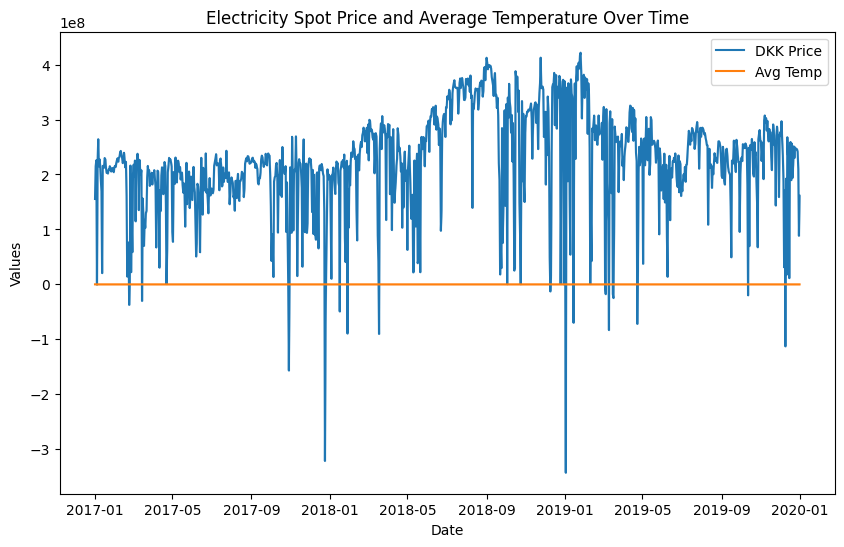

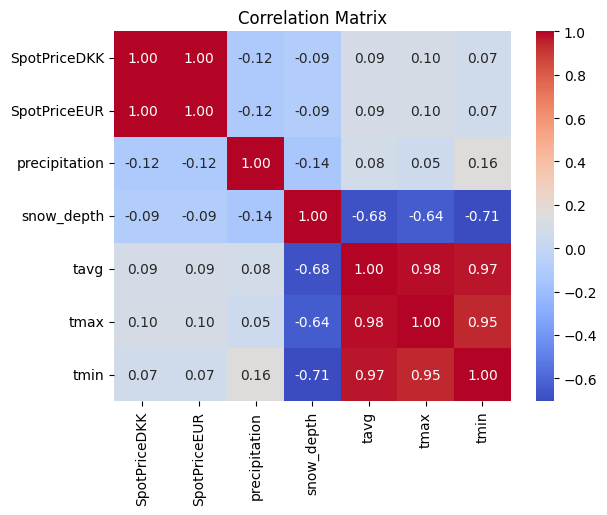

In [7]:
# Remove duplicates (if any)
merged_df = merged_df.drop_duplicates()

# Reset the index for easier manipulation
merged_df.reset_index(inplace=True)

merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Visualize relationships between electricity prices and weather variables
plt.figure(figsize=(10, 6))
sns.lineplot(x='HourUTC', y='SpotPriceDKK', data=merged_df, label='DKK Price')
sns.lineplot(x='HourUTC', y='tavg', data=merged_df, label='Avg Temp')
plt.title('Electricity Spot Price and Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# Explore correlations
corr = merged_df[['SpotPriceDKK', 'SpotPriceEUR', 'precipitation', 'snow_depth', 'tavg', 'tmax', 'tmin']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
